<a href="https://colab.research.google.com/github/jcjr64/CIND820/blob/main/Codes/LSTMcode1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas pdfplumber beautifulsoup4 requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 71.7 MB/s eta 0:00:00


In [ ]:
import pdfplumber
import pandas as pd
import glob
import re
from dateutil.parser import parse

In [ ]:
#Loading the Loughran-McDonald Master Dictionary

lm_dict = pd.read_csv('/content/Dict/Loughran-McDonald_MasterDictionary_1993-2021 (1).csv')
positive_words = lm_dict[lm_dict['Positive'] > 0]['Word'].str.lower().tolist()
negative_words = lm_dict[lm_dict['Negative'] > 0]['Word'].str.lower().tolist()

In [ ]:
def extract_date_from_filename(file_name):
    date_pattern = '\d{4}-\d{2}-\d{2}'  # Adjust based on your file naming convention
    match = re.search(date_pattern, file_name)
    if match:
        return parse(match.group(0)).date()
    return None

In [ ]:
def parse_pdf(file_path):
    text = ''
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ''
    return text

In [ ]:
def analyze_sentiment(text):
    words = text.lower().split()
    pos_count = sum(word in positive_words for word in words)
    neg_count = sum(word in negative_words for word in words)
    return pos_count - neg_count  # Simple sentiment score: positive - negative

In [ ]:
def process_pdfs_in_directory(directory_path):
    results = []

    for file_path in glob.glob(f"{directory_path}/*.pdf"):
        file_name = file_path.split('/')[-1]
        date = extract_date_from_filename(file_name)
        text = parse_pdf(file_path)
        sentiment_score = analyze_sentiment(text)

        results.append({
            'file_name': file_name,
            'date': date,
            'sentiment_score': sentiment_score,
            'average_sentiment_score': sentiment_score  # Since we're treating the entire PDF as a single unit
        })

    return results

In [ ]:
pdf_directory = '/content/SECdated'  # Replace with the actual path to your PDF files
pdf_results = process_pdfs_in_directory(pdf_directory)

# Display the results
for result in pdf_results:
    print(f"File: {result['file_name']}, Date: {result['date']}, Average Sentiment Score: {result['average_sentiment_score']}")

File: 2020-09-30.pdf, Date: 2020-09-30, Average Sentiment Score: -38
File: 2022-08-16.pdf, Date: 2022-08-16, Average Sentiment Score: 0
File: 2023-09-28.pdf, Date: 2023-09-28, Average Sentiment Score: -147
File: 2021-06-11.pdf, Date: 2021-06-11, Average Sentiment Score: -146
File: 2020-09-25.pdf, Date: 2020-09-25, Average Sentiment Score: -105
File: 2021-07-14.pdf, Date: 2021-07-14, Average Sentiment Score: -41
File: 2022-09-29.pdf, Date: 2022-09-29, Average Sentiment Score: -116
File: 2022-12-14.pdf, Date: 2022-12-14, Average Sentiment Score: -188
File: 2022-08-01.pdf, Date: 2022-08-01, Average Sentiment Score: -193
File: 2023-06-05.pdf, Date: 2023-06-05, Average Sentiment Score: -199
File: 2017-07-25.pdf, Date: 2017-07-25, Average Sentiment Score: -50
File: 2018-09-11 (2).pdf, Date: 2018-09-11, Average Sentiment Score: -47
File: 2022-11-04.pdf, Date: 2022-11-04, Average Sentiment Score: -139
File: 2021-09-01.pdf, Date: 2021-09-01, Average Sentiment Score: -224
File: 2023-01-12.pdf, D

In [ ]:
import pandas as pd

# Load Bitcoin prices
btc_prices = pd.read_csv('/content/BTC-USD/BTC-USD (1).csv', usecols=['Date', 'Close'], parse_dates=['Date'])
btc_prices.set_index('Date', inplace=True)

In [ ]:
# Convert PDF sentiment results to DataFrame
pdf_sentiments = pd.DataFrame(pdf_results)
pdf_sentiments['date'] = pd.to_datetime(pdf_sentiments['date'])  # Ensure 'date' is datetime type
pdf_sentiments.set_index('date', inplace=True)

# Merge sentiment scores with Bitcoin prices
merged_data = btc_prices.join(pdf_sentiments['average_sentiment_score']).fillna(0)  # Fill missing sentiment scores with 0

In [ ]:
pip install numpy

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]  # Assuming the 'Close' price is the first column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
87/87 [==============================] - 8s 33ms/step - loss: 0.0082 - val_loss: 7.7631e-04
Epoch 2/25
87/87 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 9.0624e-04
Epoch 3/25
87/87 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.7121e-04
Epoch 4/25
87/87 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.7091e-04
Epoch 5/25
87/87 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 7.4257e-04
Epoch 6/25
87/87 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/25
87/87 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/25
87/87 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 7.6601e-04
Epoch 9/25
87/87 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 7.6028e-04
Epoch 10/25
87/87 [==============================] - 1s 17ms/step - loss: 0.0013 

In [ ]:
predicted_prices = model.predict(X_test)
# Inverse transform to get actual values
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Compare against the actual closing prices
actual_prices = scaler.inverse_transform(scaled_data[train_size+seq_length:])[:,0]


22/22 [==============================] - 1s 4ms/step


In [ ]:
pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

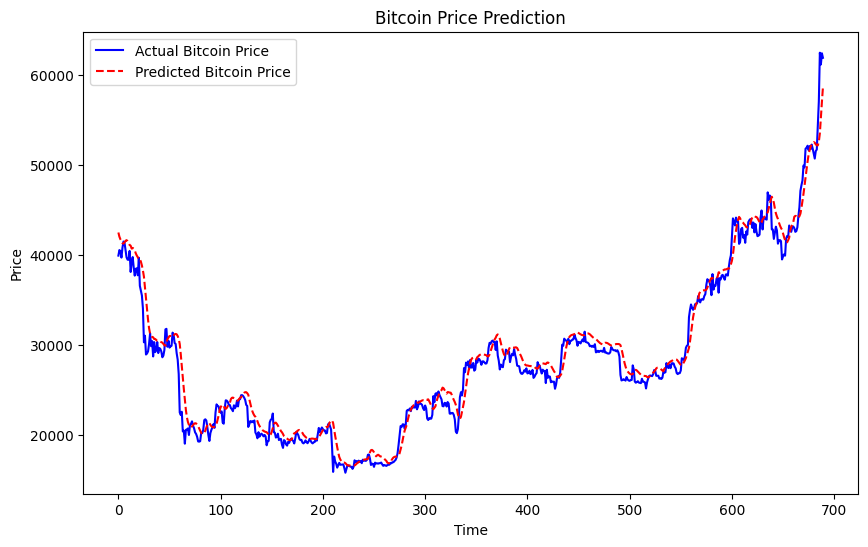

In [ ]:
#Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Bitcoin Price')
plt.plot(predicted_prices, color='red', linestyle='dashed', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
residuals = actual_prices - predicted_prices


In [ ]:
residuals_mean = np.mean(residuals)
residuals_median = np.median(residuals)
residuals_std = np.std(residuals)
residuals_min = np.min(residuals)
residuals_max = np.max(residuals)

print("Mean:", residuals_mean)
print("Median:", residuals_median)
print("Standard Deviation:", residuals_std)
print("Min:", residuals_min)
print("Max:", residuals_max)


Mean: -585.3668284297102
Median: -660.1133845916029
Standard Deviation: 1471.5004357052762
Min: -7622.491107401751
Max: 8972.605934076426


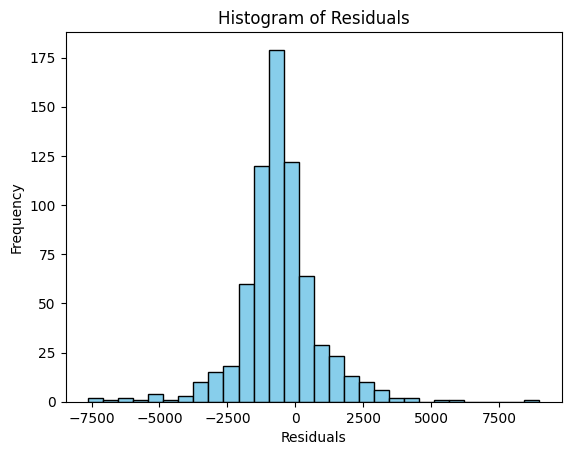

In [ ]:
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


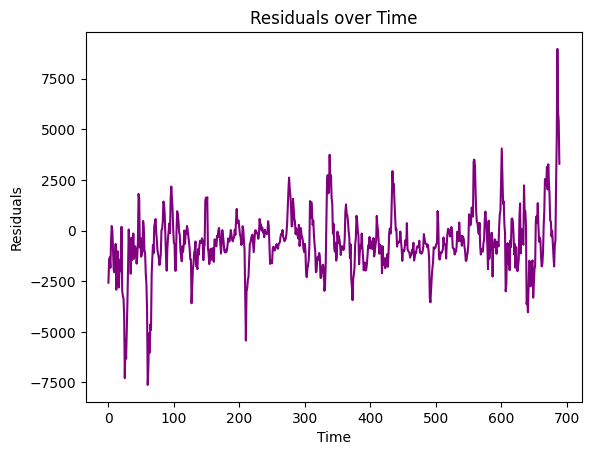

In [ ]:
plt.plot(residuals, color='purple')
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


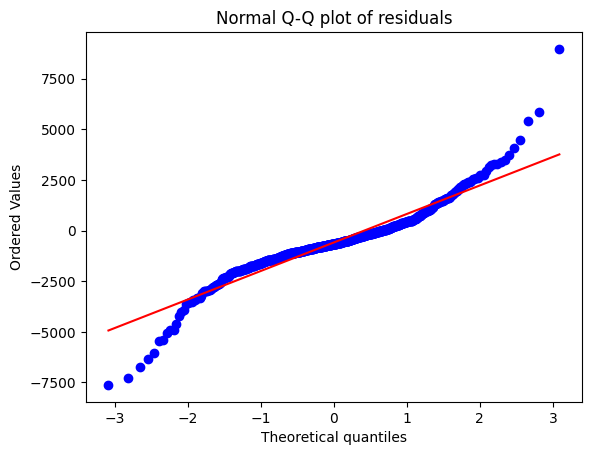

In [ ]:
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot of residuals")
plt.show()


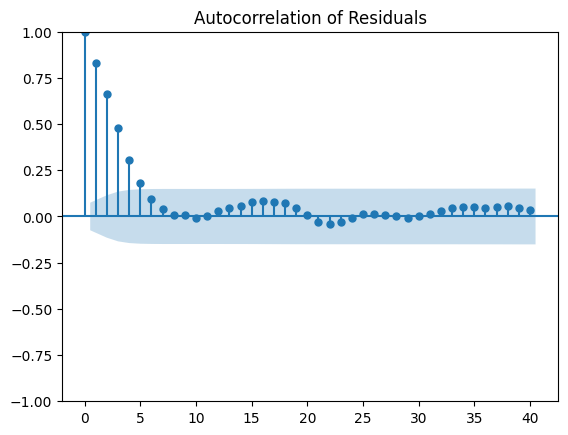

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()


In [ ]:
window_size = 7  # 7-day moving average

weights = np.ones(window_size) / window_size
moving_averages = np.convolve(actual_prices, weights, mode='valid')


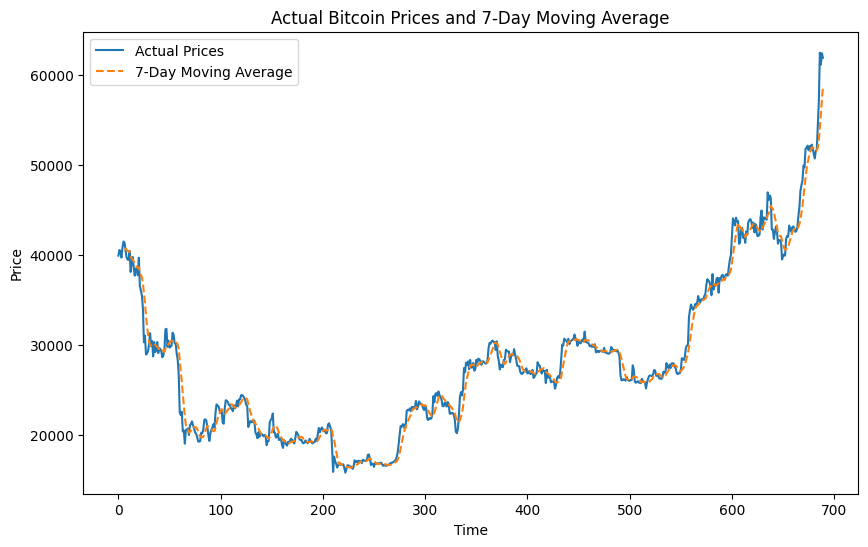

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(range(window_size-1, len(moving_averages)+window_size-1), moving_averages, label='7-Day Moving Average', linestyle='--')
plt.title('Actual Bitcoin Prices and 7-Day Moving Average')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(actual_prices, predicted_prices)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 2507967.8561066757
Root Mean Squared Error: 1583.656482986975
